In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

np.random.seed(42)

def read_kaggle_json(filepath):
    filepath = os.path.expanduser(filepath)
    username = None
    token = None
    with open(filepath, "r") as file:
        config = json.load(file)
        username = config.get("username")
        token = config.get("key")
    return username, token


kaggle_json_filepath = "/workspaces/fall-2024-class-08/kaggle/kaggle.json"
kaggle_username, kaggle_api_token = read_kaggle_json(kaggle_json_filepath)

if kaggle_username and kaggle_api_token:
    os.environ["KAGGLE_USERNAME"] = kaggle_username
    os.environ["KAGGLE_KEY"] = kaggle_api_token

import kaggle

dataset_name = "andrewmvd/sp-500-stocks"
download_location = "/workspaces/fall-2024-class-08/downloads"

kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    dataset_name, path=download_location, unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks


In [2]:
stocks_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_stocks.csv"
index_file_path = "/workspaces/fall-2024-class-08/downloads/sp500_index.csv"
companies_file_path = (
    "/workspaces/fall-2024-class-08/downloads/sp500_companies.csv"
)

stocks_df = pd.read_csv(stocks_file_path)
index_df = pd.read_csv(index_file_path)
companies_df = pd.read_csv(companies_file_path)
dates = stocks_df["Date"].unique()

technology_symbols_sorted_by_marketcap = companies_df[
    companies_df["Sector"] == "Technology"
].sort_values(by="Marketcap", ascending=False)["Symbol"]

top_ten_technology_symbols = technology_symbols_sorted_by_marketcap[:10]

print(top_ten_technology_symbols)

0     AAPL
1     NVDA
2     MSFT
9     AVGO
16    ORCL
26     CRM
30     AMD
34    CSCO
35     ACN
36    ADBE
Name: Symbol, dtype: object


In [3]:
from notebooks.feature_extraction import get_individual_stock_df

In [4]:
df = get_individual_stock_df(stocks_df, "AAPL")
df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
145548,2010-01-04,AAPL,6.454506,7.643214,7.660714,7.585000,7.622500,493729600.0
145549,2010-01-05,AAPL,6.465664,7.656429,7.699643,7.616071,7.664286,601904800.0
145550,2010-01-06,AAPL,6.362820,7.534643,7.686786,7.526786,7.656429,552160000.0
145551,2010-01-07,AAPL,6.351058,7.520714,7.571429,7.466071,7.562500,477131200.0
145552,2010-01-08,AAPL,6.393281,7.570714,7.571429,7.466429,7.510714,447610800.0


<Axes: >

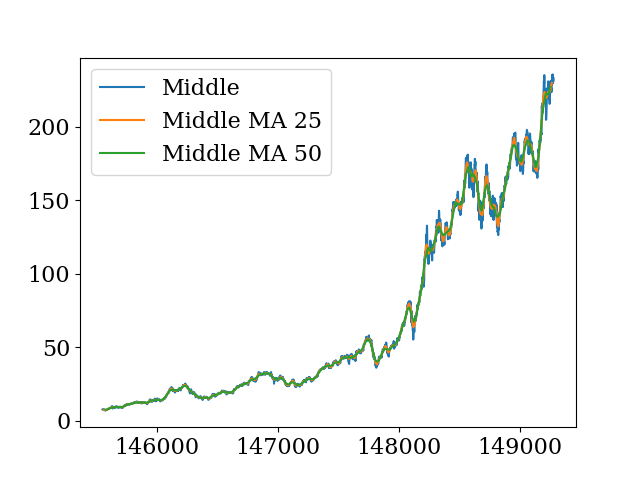

In [5]:
df["Middle"] = (df["High"] + df["Low"]) / 2
df["Middle MA 25"] = df["Middle"].rolling(window=25, center=True).mean()
df["Middle MA 50"] = df["Middle"].rolling(window=50, center=True).mean()

df[["Middle", "Middle MA 25", "Middle MA 50"]].plot()

In [6]:
from scipy.signal import find_peaks

<Axes: >

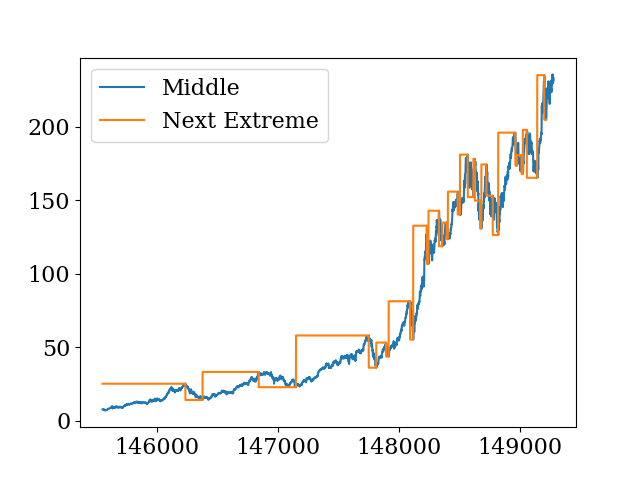

In [7]:
def next_extreme_values(series):
    peak_indices, _ = find_peaks(
        series, threshold=0, distance=40, prominence=9, width=5
    )
    valley_indices, _ = find_peaks(
        -series, threshold=0, distance=40, prominence=9, width=5
    )
    extreme_indices = np.sort(np.concatenate((peak_indices, valley_indices)))
    next_extremes = np.full(len(series), np.nan)
    for i in range(len(series)):
        future_extremes = extreme_indices[extreme_indices > i]
        if future_extremes.size > 0:
            next_extremes[i] = series[future_extremes[0]]
    return next_extremes


df["Next Extreme"] = next_extreme_values(df["Middle"].to_numpy())
df[["Middle", "Next Extreme"]].plot()

<Axes: >

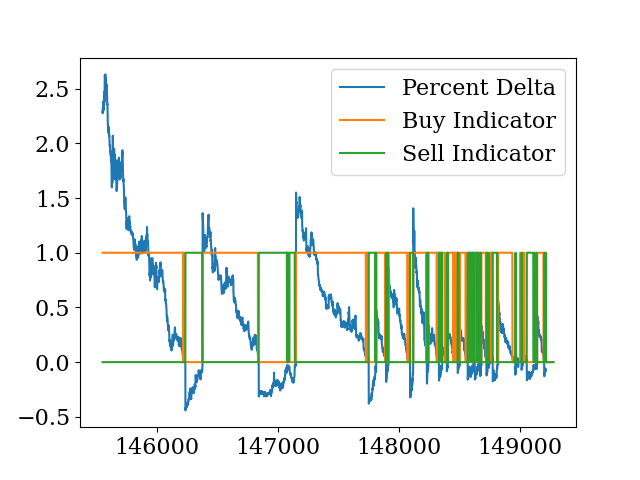

In [8]:
delta = df["Next Extreme"].to_numpy() - df["Middle"].to_numpy()

percent_delta = delta / df["Middle"].to_numpy()

buy_threshold = 0.05
sell_threshold = -0.05
df["Percent Delta"] = percent_delta
df["Buy Indicator"] = (percent_delta > buy_threshold).astype(int)
df["Sell Indicator"] = (percent_delta < sell_threshold).astype(int)
df[["Percent Delta", "Buy Indicator", "Sell Indicator"]].plot()